In [1]:
import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup
import bs4
import pymysql
import requests
from pandas import DataFrame,Series
import datetime


In [2]:
class Craweling(object):
    def __init__(self, url, idrange):
        self.url = url
        self.idrange = idrange
        self.idlist = set([]) # record of players who has been read
    
    # get raw text from a website page
    def getPage(self, i_d):
        s_i_d = str(i_d)
        r = requests.get(self.url + s_i_d)
        if not r.ok:
            print('connection error')
        return r
    
    # clean the raw text, return a dataframe
    def getPageItem(self, i_d):
        temp = self.getPage(i_d)
        #apply BeautifulSoup to generate a structured dataframe
        soup = BeautifulSoup(temp.text, "lxml")
        
        #athlete
        if not soup.find(name = 'h1'):
            return False
        athlete = soup.h1.string[11:]


        #score
        score_ = soup.find_all(text = re.compile(r'(-.+?,.+?-.+?)|(by default)'))
        w1,w2,w3,w4,w5=[],[],[],[],[]
        l1,l2,l3,l4,l5=[],[],[],[],[]
        wlset = []
        #split score to win/lose
        
        

        for score in score_:
            if not re.search(r'by default',score):
                temp = score.strip().split(',')
                w = [0]*5
                l = [0]*5
                count = 0
                for smallscore in temp:
                    splitscore = smallscore.strip().split('-')
                    w[count] = int(splitscore[0])
                    l[count] = int(splitscore[1])
                    count += 1
                wl = count
                w1.append(w[0]),w2.append(w[1]),w3.append(w[2]),w4.append(w[3]),w5.append(w[4])
                l1.append(l[0]),l2.append(l[1]),l3.append(l[2]),l4.append(l[3]),l5.append(l[4])
                wlset.append(wl)
            else:
                w1.append(0),w2.append(0),w3.append(0),w4.append(0),w5.append(0)
                l1.append(0),l2.append(0),l3.append(0),l4.append(0),l5.append(0)
                wlset.append(-1)
        d_score_error = ~(np.array(wlset)==-1) # delete score error


        #types 
        type_ = soup.find_all(text = re.compile(r'(\xa0\n.+Single|Double)|(en\'s.+Singles)'))
        
        
        d_types = []
        for t in np.array(type_):
            if re.search(r'Singles',t):
                d_types.append(True)  
            else:
                d_types.append(False)
        d_type_error = np.array(d_types)
        #d_type_error: a bool np.array. Singles value = True, doubles value = False. Drop doubles. 
       

        #names and result
        results_ = soup.find_all(text = re.compile(r'(def\.)|(lost to)'))
       

        #results of each game
        results = []

        #winner and loser :a list of the first player for each game. It Still has doubles.                 
        winner = []
        loser = []
        for t in results_:
            result = t.strip()
            results.append(result)
            name = t.find_next(href = re.compile(r'Players'))['href'][15:]
            if result == 'def.':
                winner.append(i_d)
                loser.append(name)
            else:
                winner.append(name)
                loser.append(i_d)
        win_n = np.array(winner,dtype = int)
        loss_n = np.array(loser,dtype = int)
        
        

        #dates
        #meets
        dates = []
        meets = []
        date_= soup.find_all(href = re.compile(r'MeetReport'))

        for date in date_:
            dates.append(datetime.datetime.strptime(date.string.strip(),"%m/%d/%Y"))
            meet_ = date.find_next(text = re.compile(r'[a-zA-Z]')).strip()
            meets.append(meet_)    
           
        date_n = np.array(dates,dtype=datetime.date)
        
        d_date_error = date_n > datetime.datetime.strptime("2001-10-01","%Y-%m-%d")
        
        data = {'Date':date_n, 'Meet':meets, 
                'Winner_id':win_n, "Loser_id":loss_n,
                "w1":w1,"w2":w3,"w3":w3,"w4":w4,"w5":w5,
                "l1":l1,"l2":l2,"l3":l3,"l4":l4,"l5":l5,
                "wl":wlset}
        
        #repeated records
        d_repeated = self.__repeated(win_n) & self.__repeated(loss_n)
        
        
        #drop the error and repeated records
        droperror = (d_type_error&d_score_error&d_date_error&d_repeated)
        df = DataFrame(data)[droperror]
#         df = DataFrame(data)
        
        # add this player in idlist
        self.idlist.add(int(i_d))
             
        return df
    
    
    def __repeated(self, ids):
        d_id = []
        for i in ids:
            if i in self.idlist:
                d_id.append(False)
            else:
                d_id.append(True)
        return np.array(d_id)

  
    
    
    
    
class Craweling_athlete(object):
    def __init__(self,url,idrange):
        self.idrange=idrange
        self.url=url
        
    def getPageItem(self, i_d):
        player_data = pd.read_html(self.url+str(i_d), header = 0)
        player_data[0]['player_id']=list([i_d]*len(player_data[0]))
        if len(player_data[0])==0:
            return False
        return player_data[0]
        
class Craweling_current_rating(Craweling_athlete):
    def getPageItem(self,i_d):
        r = requests.get(self.url + str(i_d))
        if not r.ok:
            print('connection error')
            return False
        soup = BeautifulSoup(r.text, "lxml")
        title = soup.find(text = re.compile(r'Current NCTTA Rating.+'))
        rating = title.next_element.string.strip()
#         print(rating)
        if not re.match(r'[0-9]+', rating):
            return False
        rating = int(rating)
        player_rating = pd.DataFrame({'player_id':[i_d], 'current_rating':[rating]})
        return player_rating


   



In [3]:
from sqlalchemy import create_engine


class DatabaseConnect(object):
    def __init__(self, username, password, host, dbname):
        self.DB_CON_STR = 'mysql+pymysql://' + username +':'\
        + password +'@'+ host +'/' + dbname +'?charset=utf8'
        self.engine = create_engine(self.DB_CON_STR, echo = False)
        
    def read(self, sql):
        return pd.read_sql(sql, con=self.engine)
    
    def write(self, df, table):
        if type(df) != bool:
            df.to_sql(table, self.engine, if_exists = 'append')
        
    def write_crawler(self, crawler, table):
        if len(crawler.idrange)==1:
            id_list = range(1,crawler.idrange)
        else:
            id_list = crawler.idrange
        for i in id_list:
            if i%100 == 0:
                print(i)
            try:    
                df = crawler.getPageItem(i)
                self.write(df, table)
            except Exception as e:
                print('TypeErrror:', e)
                print(i)
            except ValueError as e:
                print('ValueError:', e)
                print(i)

In [4]:
#download score records to database

username = 'root'
password = 'bgzwosdfz0617..'
host = 'localhost:3306'
dbname = 'nctta_rating'

url = "http://danserver.com/nctta/IndivMatches.asp?id="
crawlor = Craweling(url,13870)
DBC = DatabaseConnect(username, password, host, dbname)    


In [ ]:
DBC.write_crawler(crawlor,'score_history')

In [5]:
result = DBC.read('Select * from score_history')
player_id = np.unique(result['Loser_id'].append(result['Winner_id']))


In [6]:
url1 = "http://danserver.com/nctta/PlayerRatingHistory.aspx?PlayerId="
player_c = Craweling_athlete(url1, player_id)


In [7]:
url2 = "http://danserver.com/nctta/Players.asp?id="
player_r = Craweling_current_rating(url2, player_id)


In [62]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

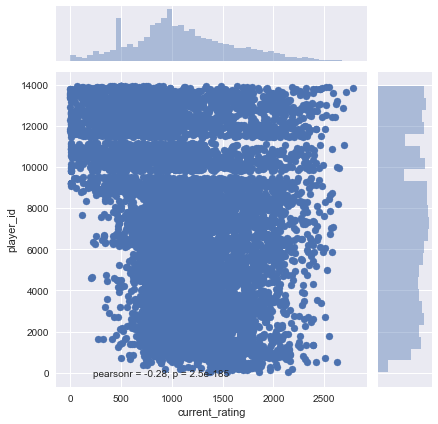

In [64]:
current_rating = DBC.read("Select * from current_rating")
sns.jointplot(x=current_rating['current_rating'], y=current_rating['player_id'])